In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import time

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


# MS2

In [7]:
df_ms2 = pd.read_csv('df_modeling_211124_result.msms', sep='\t')

In [8]:
print(df_ms2.shape)
df_ms2.head(1)

(2385750, 5)


,Intensities,Masses,Matches,Modified Sequence,Charge
0,0.16607068;0.22559804;1.0;0.10618063;0.1724560...,147.112804167;261.155731167;358.20849516699997...,y1;y2;y3;y4;y5;y6;y7;y8;y9;y10;y11;y12;y13;y14...,QELNEPPKQSTSFLVLQEILESEEKGDPNK,3


In [9]:
def get_ion_type():
    # y1 ~ y29, b1 ~ b29, y1(2+) ~ y29(2+), ... , b1(3+) ~ b29(3+)
    ion_num_arr = list(map(str, range(1, 30)))
    ion_type_arr = ['y', 'b']
    ion_charge_arr = ['', '(2+)', '(3+)']
    ion_arr = []
    for ic in ion_charge_arr:
        for it in ion_type_arr:
            for inum in ion_num_arr:
                ion_arr.append(it+inum+ic)
    return ion_arr

def ms_to_174(intens, matches):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    return ion_dic

def ms_to_29(intens, matches, pep):
    i = list(map(float, intens.split(';')))
    m = matches.split(';')
    ion_dic = {k:v for k, v in zip(m, i)}

    ion_arr = get_ion_type()
    for ion in ion_arr:
        if ion not in ion_dic:
            ion_dic[ion] = 0
    
    # fragmentation part
    ion_y1c = ['y' + str(i) for i in range(1, len(pep))]
    ion_y2c = ['y' + str(i) + '(2+)' for i in range(1, len(pep))]
    ion_y3c = ['y' + str(i) + '(3+)' for i in range(1, len(pep))]
    ion_b1c = ['b' + str(i) for i in range(len(pep)-1, 0, -1)]
    ion_b2c = ['b' + str(i) + '(2+)' for i in range(len(pep)-1, 0, -1)]
    ion_b3c = ['b' + str(i) + '(3+)'  for i in range(len(pep)-1, 0, -1)]
    
    ion_sum = {i:0 for i in range(1, 30)}
    for idx, i in enumerate(range(1, len(pep))):
        y1c = ion_dic[ion_y1c[idx]]
        y2c = ion_dic[ion_y2c[idx]]
        y3c = ion_dic[ion_y3c[idx]]
        b1c = ion_dic[ion_b1c[idx]]
        b2c = ion_dic[ion_b2c[idx]]
        b3c = ion_dic[ion_b3c[idx]]
        
        ion_sum[i] = y1c + y2c + y3c + b1c + b2c + b3c
    
    return list(np.array(sorted(ion_sum.items()))[:, 1])

In [10]:
s = time.time()

p2ms2 = dict()
for i, m, p, c in df_ms2[['Intensities', 'Matches', 'Modified Sequence', 'Charge']].values:
    if p not in p2ms2:
        p2ms2[p] = {k:[0 for _ in range(1, 30)] for k in range(1, 6)}
    p2ms2[p][c] = ms_to_29(i, m, p)

e = time.time()
print('time: ', round(e-s, 2), 'sec')

time:  334.36 sec


In [11]:
pep_to_ms = dict()
for k, v in p2ms2.items():
    tensor = np.array(sorted(v.items()))[:, 1]
    ms2arr = np.concatenate(tensor, axis=None)
    pep_to_ms[k] = ms2arr

/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
h_train = np.array([pep_to_ms[p] for p in train.PEP.values])
c_train = h_train.copy()
h_val = np.array([pep_to_ms[p] for p in val.PEP.values])
c_val = h_val.copy()

h_test = np.array([pep_to_ms[p] for p in test.PEP.values])
c_test = h_test.copy()

# Train

In [13]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

from tensorflow import keras

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

# high param

In [16]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(n_embed)
n_lstm = tf.keras.layers.Dense(8, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(c_embed)
c_lstm = tf.keras.layers.Dense(8, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m1_embed)
m1_lstm = tf.keras.layers.Dense(8, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m2_embed)
m2_lstm = tf.keras.layers.Dense(8, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(pep_embed)
pep_lstm = tf.keras.layers.Dense(16, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)

h_0 = tf.keras.layers.Input(shape=((145,)))
ms_net = tf.keras.layers.Dense(64, activation='relu')(h_0)
ms_net = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(ms_net)
ms_net = tf.keras.layers.Dense(32, activation='relu')(ms_net)
ms_net = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(ms_net)

# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm,
                                     ms_net])

net_merge = tf.keras.layers.Dense(64, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(32, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[h_0, pep, meta, n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 15)]         0                                            
____________________________________________________________________________________________

In [17]:
history = model_high.fit([h_train, pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=256,
                    validation_data=([h_val, pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
2124/2124 [==============================] - 330s 141ms/step - loss: 1.3680 - accuracy: 0.6106 - val_loss: 0.4651 - val_accuracy: 0.7787
Epoch 2/300
2124/2124 [==============================] - 288s 136ms/step - loss: 0.4760 - accuracy: 0.7773 - val_loss: 0.4425 - val_accuracy: 0.7927
Epoch 3/300
2124/2124 [==============================] - 293s 138ms/step - loss: 0.4472 - accuracy: 0.7951 - val_loss: 0.4263 - val_accuracy: 0.8041
Epoch 4/300
2124/2124 [==============================] - 289s 136ms/step - loss: 0.4355 - accuracy: 0.8014 - val_loss: 0.4171 - val_accuracy: 0.8101
Epoch 5/300
2124/2124 [==============================] - 297s 140ms/step - loss: 0.4265 - accuracy: 0.8065 - val_loss: 0.4123 - val_accuracy: 0.8128
Epoch 6/300
2124/2124 [==============================] - 300s 141ms/step - loss: 0.4224 - accuracy: 0.8082 - val_loss: 0.4083 - val_accuracy: 0.8144
Epoch 7/300
2124/2124 [==============================] - 286s 135ms/step - loss: 0.4149 - accuracy: 0.8123

Epoch 56/300
2124/2124 [==============================] - 281s 133ms/step - loss: 0.3735 - accuracy: 0.8330 - val_loss: 0.3855 - val_accuracy: 0.8278
Epoch 57/300
2124/2124 [==============================] - 280s 132ms/step - loss: 0.3729 - accuracy: 0.8346 - val_loss: 0.3824 - val_accuracy: 0.8294
Epoch 58/300
2124/2124 [==============================] - 275s 130ms/step - loss: 0.3726 - accuracy: 0.8343 - val_loss: 0.3836 - val_accuracy: 0.8296
Epoch 59/300
2124/2124 [==============================] - 279s 131ms/step - loss: 0.3715 - accuracy: 0.8347 - val_loss: 0.3823 - val_accuracy: 0.8291
Epoch 60/300
2124/2124 [==============================] - 277s 131ms/step - loss: 0.3717 - accuracy: 0.8339 - val_loss: 0.3821 - val_accuracy: 0.8295
Epoch 61/300
2124/2124 [==============================] - 276s 130ms/step - loss: 0.3718 - accuracy: 0.8339 - val_loss: 0.3817 - val_accuracy: 0.8303
Epoch 62/300
2124/2124 [==============================] - 280s 132ms/step - loss: 0.3714 - accuracy:

2124/2124 [==============================] - 317s 149ms/step - loss: 0.3618 - accuracy: 0.8392 - val_loss: 0.3790 - val_accuracy: 0.8310
Epoch 111/300
2124/2124 [==============================] - 325s 153ms/step - loss: 0.3606 - accuracy: 0.8400 - val_loss: 0.3792 - val_accuracy: 0.8311
Epoch 112/300
2124/2124 [==============================] - 320s 151ms/step - loss: 0.3623 - accuracy: 0.8388 - val_loss: 0.3796 - val_accuracy: 0.8316
Epoch 113/300
2124/2124 [==============================] - 318s 150ms/step - loss: 0.3623 - accuracy: 0.8396 - val_loss: 0.3797 - val_accuracy: 0.8316
Epoch 114/300
2124/2124 [==============================] - 327s 154ms/step - loss: 0.3611 - accuracy: 0.8400 - val_loss: 0.3802 - val_accuracy: 0.8319
Epoch 115/300
2124/2124 [==============================] - 318s 150ms/step - loss: 0.3606 - accuracy: 0.8405 - val_loss: 0.3789 - val_accuracy: 0.8315
Epoch 116/300
2124/2124 [==============================] - 319s 150ms/step - loss: 0.3607 - accuracy: 0.8400

2124/2124 [==============================] - 268s 126ms/step - loss: 0.3542 - accuracy: 0.8432 - val_loss: 0.3793 - val_accuracy: 0.8324
Epoch 165/300
2124/2124 [==============================] - 288s 136ms/step - loss: 0.3546 - accuracy: 0.8426 - val_loss: 0.3804 - val_accuracy: 0.8322
Epoch 166/300
2124/2124 [==============================] - 277s 130ms/step - loss: 0.3541 - accuracy: 0.8438 - val_loss: 0.3785 - val_accuracy: 0.8322
Epoch 167/300
2124/2124 [==============================] - 276s 130ms/step - loss: 0.3538 - accuracy: 0.8432 - val_loss: 0.3784 - val_accuracy: 0.8323
Epoch 168/300
2124/2124 [==============================] - 285s 134ms/step - loss: 0.3548 - accuracy: 0.8424 - val_loss: 0.3784 - val_accuracy: 0.8323
Epoch 169/300
2124/2124 [==============================] - 277s 130ms/step - loss: 0.3555 - accuracy: 0.8423 - val_loss: 0.3787 - val_accuracy: 0.8318
Epoch 170/300
2124/2124 [==============================] - 253s 119ms/step - loss: 0.3540 - accuracy: 0.8428

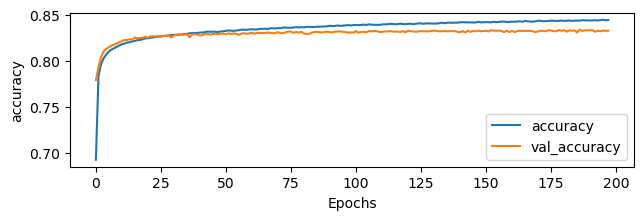

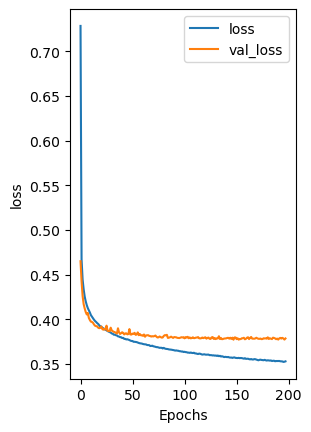

In [18]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4188/4188 [==============================] - 145s 35ms/step - loss: 0.3727 - accuracy: 0.8334
Test Loss: 0.3726549446582794
Test Accuracy: 0.8333631753921509
              precision    recall  f1-score   support

           0       0.87      0.79      0.83     66996
           1       0.81      0.88      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.84      0.83      0.83    133992
weighted avg       0.84      0.83      0.83    133992

rf auc : 0.9160594879101288


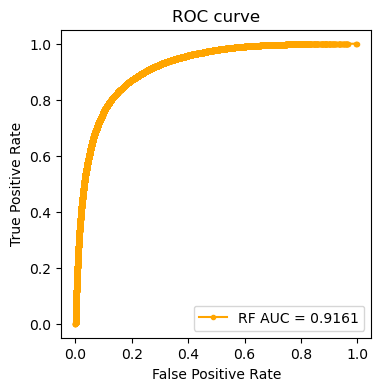

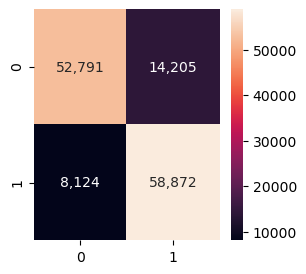

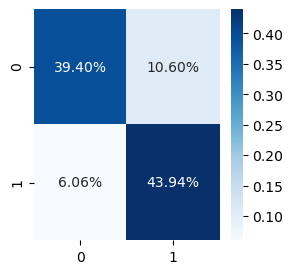

In [19]:
test_loss, test_acc = model_high.evaluate([h_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([h_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([h_test, pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [199]:
# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_high.save("compareModel/2021KSBi_multi_ms2/")

# # It can be used to reconstruct the model identically.
# model_high_re = keras.models.load_model("compareModel/2021KSBi_multi_ms2/")